In [ ]:
# https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/
# mount Google Drive so we can access it
from google.colab import drive
drive.mount('/content/gdrive')  # should be able to mount just UAV folder next time

Mounted at /content/gdrive


In [ ]:
# file paths to our data
!ls 'gdrive/Shareddrives/CPSC 4176 Project Spring 2023/UAV Data'

'Error evidence'	 'UAV 3 Information.txt'  'UAV 5.mp4'
'UAV 1 Data.xlsx'	 'UAV 3.mp4'		  'UAV 5 Road Layout.jpg'
'UAV 1 Information.txt'  'UAV 3 Road Layout.png'  'UAV 6 Data frenet.csv'
'UAV 1.mp4'		  UAV_4_Data_down.xlsx	  'UAV 6 Data pixel.csv'
'UAV 1 Road Layout.png'   UAV_4_Data_up.xlsx	  'UAV 6 Information.txt'
'UAV 2 Data.xlsx'	 'UAV 4 Information.txt'  'UAV 6.mp4'
'UAV 2 Information.txt'  'UAV 4.mp4'		  'UAV 6 Road Layout.png'
'UAV 2.mp4'		 'UAV 4 Road Layout.jpg'  'UAV 6 timespace data.jpg'
'UAV 2 Road Layout.png'  'UAV 5 Data.xlsx'
'UAV 3 Data.xlsx'	 'UAV 5 Information.txt'


In [ ]:
from tensorflow import keras
import pandas as pd

In [ ]:
url = "gdrive/Shareddrives/CPSC 4176 Project Spring 2023/UAV Data/UAV_4_Data_down.xlsx"
#You can specify the sheet name
#data = pd.read_excel(url, sheet_name= "Sheet1")
#data = pd.read_excel(url, sheet_name= 0)
#data = pd.read_excel(url)

#Read all sheets in the Excel file
data = pd.read_excel(url, sheet_name=None)

#df will be a dictionary, where the keys are the sheet names and the values are the corresponding dataframes
#print(df.keys())
#print(df["Sheet1"])
#print(df["Sheet2"])
#print(df["Sheet3"])


In [ ]:
# since each sheet is it's own lane, we can remove LaneID
#data = data.drop(labels='LaneID', axis=1)
data2 = data["sheet2"]
data2 =data2.drop(labels='LaneID', axis=1)
#Sheet1, sheet2, sheet3, sheet4, sheet5

In [ ]:
print(data.keys())
print(len(data.keys()))

dict_keys(['Sheet1', 'sheet2', 'sheet3', 'sheet4', 'sheet5'])
5


In [ ]:
data2.shape

(426713, 9)

In [ ]:
print(data["x-axis position(m)"].max())


356.9378329610643


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

<AxesSubplot:title={'center':'All Vehicles Lane 1'}, xlabel='Time(s)'>

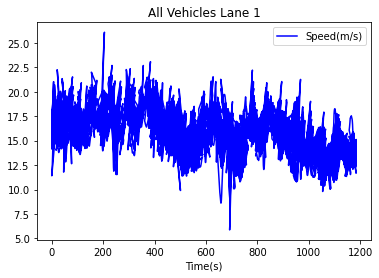

In [ ]:
# displays all vehicles speed and times for Lane 1
data.plot(kind='line', x='Time(s)', y='Speed(m/s)', color='blue', title="All Vehicles Lane 1")

In [ ]:
data.describe()

In [ ]:
data.transpose()

In [ ]:
# counts and displays how many datapoints per vehicle
vehicle_datapoints = {}
for vehicle in data['VehicleID']:
  vehicle_datapoints[vehicle] = vehicle_datapoints.get(vehicle, 0) + 1
vehicle_datapoints

In [ ]:
# searches for specific VehicleID and extracts all data for that vehicle
search_vehicle_id = 13909
vehicle_data = data.loc[data['VehicleID'] == search_vehicle_id]
vehicle_data

In [ ]:
# plots individual vehicle speed, acceleration, lane position
vehicle_data.plot(kind='line', x='Time(s)', y='Speed(m/s)', color='blue', title="Vehicle: " + str(search_vehicle_id))
vehicle_data.plot(kind='line', x='Time(s)', y='Acceleration(m/s^2)', color='blue', title="Vehicle: " + str(search_vehicle_id))
vehicle_data.plot(kind='line', x='Time(s)', y='Distance from upper Lane line(m)', color='blue', title="Vehicle: " + str(search_vehicle_id))
vehicle_data.plot(kind='line', x='Time(s)', y='Distance from lower lane line(m)', color='blue', title="Vehicle: " + str(search_vehicle_id))

In [ ]:
# removed feature values to keep initial model simple
vehicle_data = vehicle_data.drop(labels='Distance from upper Lane line(m)', axis=1)
vehicle_data = vehicle_data.drop(labels='Distance from lower lane line(m)', axis=1)
vehicle_data = vehicle_data.drop(labels='VehicleLength(meter)', axis=1)
vehicle_data = vehicle_data.drop(labels='VehicleWidth(meter)', axis=1)
vehicle_data = vehicle_data.drop(labels='x-axis position(m)', axis=1)
vehicle_data = vehicle_data.drop(labels='VehicleID', axis=1)
vehicle_data = vehicle_data.reset_index()
vehicle_data = vehicle_data.drop(labels='index', axis=1)
vehicle_data

In [ ]:
# We need to normalize the data between 0 and 1
# data' is normalized between 0 and 1
# data' = (data - data_min) / (data_max - data_min)
# OR 
# data' = (data - mean) / standard deviation         
# Ex:  train_array = (train_array - mean) / std

def NormalizeData(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))
def NormalizeData2(data):
  return (data - data.mean(axis=0)) / data.std(axis=0)

normalize_data = pd.DataFrame()
normalize_data['Time'] = vehicle_data['Time(s)']
normalize_data['Speed'] = NormalizeData(vehicle_data['Speed(m/s)'])
normalize_data['Acceleration'] = NormalizeData(vehicle_data['Acceleration(m/s^2)'])

normalize_data2 = pd.DataFrame()
normalize_data2['Time'] = vehicle_data['Time(s)']
normalize_data2['Speed'] = NormalizeData2(vehicle_data['Speed(m/s)'])
normalize_data2['Acceleration'] = NormalizeData2(vehicle_data['Acceleration(m/s^2)'])

# TODO: Need to clean the data, IE: -5.whatever, and other incorrect data

In [ ]:
#data['Time(s)'][data.index]
#print(data.shape[0]-1) # This will return the last index. Do -1 this value to stop before the last.
#print(data[["Speed(m/s)","Acceleration(m/s^2)"]])
#print(data["x-axis position(m)"].min())

In [ ]:
# ---------------------------------------------------------------- DATA CLEANING SECTION [HIMANSHU BOHRA, DONGHYEON PARK] ---------------------------------------- #

# DATA CLEANING/PREP SECTION [ PRE-NORMALIZATION]

clean_file = data.copy()


# Cleaning function
def clean_speed_accel_UAV4(inputData):
  i=0
  timeConstant = 0.03333
  old_data = None
  errors_found = 0

  while(i<inputData.shape[0]-1):
    # Cleaning the speed in UAV4
    old_data = inputData["Speed(m/s)"][inputData.index[i]] # Record old data
    inputData["Speed(m/s)"][inputData.index[i]] = (inputData["x-axis position(m)"][inputData.index[i+1]] - inputData["x-axis position(m)"][inputData.index[i]]) / timeConstant
    # Add to the error count if old_data was changed
    if(old_data != inputData["Speed(m/s)"][inputData.index[i]]): errors_found = errors_found+1
    # Cleaning the accel in UAV4
    old_data = inputData["Acceleration(m/s^2)"][inputData.index[i]]
    inputData["Acceleration(m/s^2)"][inputData.index[i]] = (inputData["Speed(m/s)"][inputData.index[i+1]] -inputData["Speed(m/s)"][inputData.index[i]]) / timeConstant
    # Same for error count:
    if(old_data != inputData["Acceleration(m/s^2)"][inputData.index[i]]): errors_found = errors_found+1
    i = i+1
    return [inputData, errors_found]


# Sorting, cleaning and concatenating by VehicleIDs to prevent speed/acc miscalculation.
def sort_by_VID(inputData):
    vID_list = inputData["VehicleID"].unique()

    # Resultant array containing ALL the cleaned dataframes for individual vehicle ID rows:
    cleaned_vehicle_rows = []
    
    # Iterators:
    vid_iterator = 0

    # NESTED LOOP VARIABLES FOR ERROR COUNT
    total_errors_found = 0
    tempArray = [None, None] # Result storage to reduce processing load [clean function is expensive]

    while(vid_iterator < len(vID_list)):
      currentVehicleIDRows = data.loc[data['VehicleID'] == vID_list[vid_iterator]]

      tempArray = clean_speed_accel_UAV4(currentVehicleIDRows)
      cleaned_vehicle_rows.append(tempArray[0])
      total_errors_found = total_errors_found + tempArray[1]

      vid_iterator = vid_iterator + 1
      # END OF OUTER LOOP

    return [pd.concat( cleaned_vehicle_rows ) , total_errors_found ]


# Applying the function to clean the data
temp_result_array = sort_by_VID(clean_file)
clean_file = temp_result_array[0]
total_errors_from_cleaning = temp_result_array[1]



'''
normalized_file = pd.DataFrame()
normalized_file['VehicleID'] = data['VehicleID']
normalized_file['LaneID'] = data['LaneID']
normalized_file['Time(s)'] = data['Time(s)
normalized_file['x-axis position(m)'] = NormalizeData(data['x-axis position(m)'])
normalized_file['VehicleID'] = data['VehicleID']
normalized_file['VehicleID'] = data['VehicleID']']
'''

#clean_file["Acceleration(m/s^2)"]
print(clean_file[["Speed(m/s)","Acceleration(m/s^2)"]])

In [ ]:
# TEST AREA

#clean_file["Speed(m/s)"][clean_file.index[472239]]
#clean_file.loc[clean_file["Speed(m/s)"] == 12.852531812619823 ]
print(total_errors_from_cleaning)

1797


In [ ]:
# Saving to drive, to reduce processing load re-occurance.
#clean_file.to_excel(r'gdrive/Shareddrives/CPSC 4176 Project Spring 2023/Code/NormalizedDataExcelFile/UAV_4_Data_down_Cleaned.xlsx', index=False)

# Logging the errors from the above code block's cleaning:
with open('gdrive/Shareddrives/CPSC 4176 Project Spring 2023/Code/NormalizedDataExcelFile/UAV_4_Data_down_ERRORLOG.txt', 'w') as f:
  f.write('Total record check: ' + str(clean_file.shape[0]) + "\n")
  f.write('Total Errors Found: ' + str(total_errors_from_cleaning))


# ----------------------------------------------------------------------- END OF DATA CLEANING ----------------------------------------------------------------#


In [ ]:
# display min/max normalization
print("Max Speed: ", vehicle_data['Speed(m/s)'].max(), "Min Speed: ", vehicle_data['Speed(m/s)'].min())
print("Max Accel: ", vehicle_data['Acceleration(m/s^2)'].max(),"Min Accel: ",  vehicle_data['Acceleration(m/s^2)'].min())
print("Max Speed: ", normalize_data['Speed'].max(), "Min Speed: ", normalize_data['Speed'].min())
print("Max Accel: ", normalize_data['Acceleration'].max(),"Min Accel: ",  normalize_data['Acceleration'].min())
normalize_data

In [ ]:
# display mean/standard deviation normalization
# this doesn't scale to 0 to 1, unsure of why
print("Max Speed: ", vehicle_data['Speed(m/s)'].max(), "Min Speed: ", vehicle_data['Speed(m/s)'].min())
print("Max Accel: ", vehicle_data['Acceleration(m/s^2)'].max(),"Min Accel: ",  vehicle_data['Acceleration(m/s^2)'].min())
print("Max Speed: ", normalize_data2['Speed'].max(), "Min Speed: ", normalize_data2['Speed'].min())
print("Max Accel: ", normalize_data2['Acceleration'].max(),"Min Accel: ",  normalize_data2['Acceleration'].min())
normalize_data2

In [ ]:
# TODO: Now that data is normalized, make it into a RNN model
# Need to split into train, val, test
df_size = len(vehicle_data)
train_size = 0.7
val_size = 0.2
test_size = 0.1

train_df = vehicle_data[0:int(df_size * 0.7)]
val_df = vehicle_data[int(df_size * 0.7):int(df_size * 0.9)]
test_df = vehicle_data[int(df_size * 0.9):]
train_df

In [ ]:
# just examples of how to build a model 
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

In [ ]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()
